# PDE-FIND for $\lambda - \omega$ Reaction diffusion System

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on a reaction diffusion system exhibiting sprial waves on a periodic domain.  We derive PDE's for each of two quantities, having dependancies on each other; $u$ and $v$.  

\begin{align*}
u_t &= 0.1\nabla^2 u + \lambda(A)u - \omega(A)v\\
v_t &= 0.1\nabla^2 v + \omega(A)u + \lambda(A)v\\
A^2 &= u^2 + v^2,\, \omega(A) = -\beta A^2, \lambda(A) = 1-A^2
\end{align*}

Unlike other implmentations, we allow for $u_t$ to be dependent on derivatives of $v$, even though this is not the case in the true PDE.  The sparse regression is still able to derive the correct PDE.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = sio.loadmat('../Datasets/reaction_diffusion.mat')

FileNotFoundError: [Errno 2] No such file or directory: '../Datasets/reaction_diffusion.mat'

In [3]:
t = data['t'][:,0]
x = data['x'][0,:]
y = data['y'][0,:]
U = data['u']
V = data['v']

n = len(x) # also the length of y
steps = len(t)
dx = x[2]-x[1]
dy = y[2]-y[1]
dt = t[2]-t[1]

pylab.rcParams['figure.figsize'] = (12, 6)
figure()
xx, yy = meshgrid(
    np.arange(n)*dx,
    np.arange(n)*dy)
subplot(1,2,1)
pcolor(xx,yy,U[:,:,10],cmap='coolwarm')
title('U', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(1,2,2)
pcolor(xx,yy,V[:,:,10],cmap='coolwarm')
title('V', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (12, 8)

NameError: name 'data' is not defined

## Sample data

Since we have a very large number of data points it would take a very long time to use all of them.  Instead we'll randomly sample 150,000 (just over 1 %) of them to use in the regression.

In [4]:
# Sample a collection of data points.  See figure 1 panel 2a.
numpy.random.seed(0) # so that numbers in paper are reproducible

num_xy = 5000 # needs to be very high to work with noise
num_t = 30
num_points = num_xy * num_t
boundary = 5
points = {}
count = 0

for p in range(num_xy):
    x = np.random.choice(np.arange(boundary,n-boundary),1)[0]
    y = np.random.choice(np.arange(boundary,n-boundary),1)[0]
    for t in range(num_t):
        points[count] = [x,y,6*t+10]
        count = count + 1 

## Construct $\Theta (U)$ and compute $U_t$

First we take the derivatives around each one of the points then combine these with a number of candidate funcitons of u and v for the PDE.  All of the candidate funcitons are listed below.

In [5]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
v = np.zeros((num_points,1))
ut = np.zeros((num_points,1))
vt = np.zeros((num_points,1))
ux = np.zeros((num_points,1))
uy = np.zeros((num_points,1))
uxx = np.zeros((num_points,1))
uxy = np.zeros((num_points,1))
uyy = np.zeros((num_points,1))
vx = np.zeros((num_points,1))
vy = np.zeros((num_points,1))
vxx = np.zeros((num_points,1))
vxy = np.zeros((num_points,1))
vyy = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 4 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    
    # value of function
    u[p] = U[x,y,t]
    v[p] = V[x,y,t]
    
    # time derivatives
    ut[p] = PolyDiffPoint(U[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]
    vt[p] = PolyDiffPoint(V[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]
    
    # spatial derivatives
    ux_diff = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    uy_diff = PolyDiffPoint(U[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    vx_diff = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    vy_diff = PolyDiffPoint(V[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    ux_diff_yp = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    ux_diff_ym = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)
    vx_diff_yp = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    vx_diff_ym = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)
    
    ux[p] = ux_diff[0]
    uy[p] = uy_diff[0]
    uxx[p] = ux_diff[1]
    uxy[p] = (ux_diff_yp[0]-ux_diff_ym[0])/(2*dy)
    uyy[p] = uy_diff[1]
    
    vx[p] = vx_diff[0]
    vy[p] = vy_diff[0]
    vxx[p] = vx_diff[1]
    vxy[p] = (vx_diff_yp[0]-vx_diff_ym[0])/(2*dy)
    vyy[p] = vy_diff[1]

In [6]:
# Form Theta using up to quadratic polynomials in all variables.
X_data = np.hstack([u,v])
X_ders = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy, vx, vy, vxx, vxy, vyy])
X_ders_descr = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}','v_{x}', 'v_{y}','v_{xx}','v_{xy}','v_{yy}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u','v'])
['1'] + description[1:]

['1',
 'u_{x}',
 'u_{y}',
 'u_{xx}',
 'u_{xy}',
 'u_{yy}',
 'v_{x}',
 'v_{y}',
 'v_{xx}',
 'v_{xy}',
 'v_{yy}',
 'v',
 'u',
 'v^2',
 'uv',
 'u^2',
 'v^3',
 'uv^2',
 'u^2v',
 'u^3',
 'vu_{x}',
 'uu_{x}',
 'v^2u_{x}',
 'uvu_{x}',
 'u^2u_{x}',
 'v^3u_{x}',
 'uv^2u_{x}',
 'u^2vu_{x}',
 'u^3u_{x}',
 'vu_{y}',
 'uu_{y}',
 'v^2u_{y}',
 'uvu_{y}',
 'u^2u_{y}',
 'v^3u_{y}',
 'uv^2u_{y}',
 'u^2vu_{y}',
 'u^3u_{y}',
 'vu_{xx}',
 'uu_{xx}',
 'v^2u_{xx}',
 'uvu_{xx}',
 'u^2u_{xx}',
 'v^3u_{xx}',
 'uv^2u_{xx}',
 'u^2vu_{xx}',
 'u^3u_{xx}',
 'vu_{xy}',
 'uu_{xy}',
 'v^2u_{xy}',
 'uvu_{xy}',
 'u^2u_{xy}',
 'v^3u_{xy}',
 'uv^2u_{xy}',
 'u^2vu_{xy}',
 'u^3u_{xy}',
 'vu_{yy}',
 'uu_{yy}',
 'v^2u_{yy}',
 'uvu_{yy}',
 'u^2u_{yy}',
 'v^3u_{yy}',
 'uv^2u_{yy}',
 'u^2vu_{yy}',
 'u^3u_{yy}',
 'vv_{x}',
 'uv_{x}',
 'v^2v_{x}',
 'uvv_{x}',
 'u^2v_{x}',
 'v^3v_{x}',
 'uv^2v_{x}',
 'u^2vv_{x}',
 'u^3v_{x}',
 'vv_{y}',
 'uv_{y}',
 'v^2v_{y}',
 'uvv_{y}',
 'u^2v_{y}',
 'v^3v_{y}',
 'uv^2v_{y}',
 'u^2vv_{y}',
 'u^3v_

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [7]:
c = TrainSTRidge(X,ut,10**-5,1)
print_pde(c, description)

u_t = (0.099972 +0.000000i)u_{xx}
    + (0.100004 +0.000000i)u_{yy}
    + (0.999913 +0.000000i)u
    + (0.999979 +0.000000i)v^3
    + (-0.999882 +0.000000i)uv^2
    + (0.999977 +0.000000i)u^2v
    + (-0.999900 +0.000000i)u^3
   


In [8]:
c = TrainSTRidge(X,vt,10**-5,1)
print_pde(c, description, ut = 'v_t')

v_t = (0.100032 +0.000000i)v_{xx}
    + (0.099968 +0.000000i)v_{yy}
    + (1.000278 +0.000000i)v
    + (-1.000293 +0.000000i)v^3
    + (-0.999971 +0.000000i)uv^2
    + (-1.000268 +0.000000i)u^2v
    + (-0.999978 +0.000000i)u^3
   


In [9]:
err = abs(np.array([(0.1-0.099977)*100/0.1,  (0.1-0.100033)*100/0.1,
                    (0.1-0.100009)*100/0.1,  (0.1-0.099971)*100/0.1,
                    (1-0.999887)*100,        (1-1.000335)*100,
                    (1-0.999906)*100,        (1-0.999970)*100,
                    (1-0.999980)*100,        (1-0.999978)*100,
                    (1-0.999976)*100,        (1-1.000353)*100,
                    (1-0.999923)*100,        (1-1.000332)*100]))
print(mean(err))
print(std(err))

0.016714285714285976
0.013088645959808971


## Identify the dynamics using the same dataset but with artificial noise

In all other examples, we used 1% of the standard deviation of the solution for the magnitude of the noise added.  Even with using many more points, we weren't able to identify the correct dynamics with that noise level.  Instead we use 0.5%.

In [10]:
# Now try adding noise.
numpy.random.seed(0)
Un = U + 0.005*std(U)*np.random.randn(n,n,steps)
Vn = V + 0.005*std(V)*np.random.randn(n,n,steps)

## Denoise via SVD

Denoise via taking SVD and truncating where singular values flatten off.

In [11]:
# Denoise using POD.
FUn = Un.reshape(n**2,steps)
FVn = Vn.reshape(n**2,steps)

In [12]:
uun,usn,uvn = np.linalg.svd(FUn, full_matrices = False)
vun,vsn,vvn = np.linalg.svd(FVn, full_matrices = False)

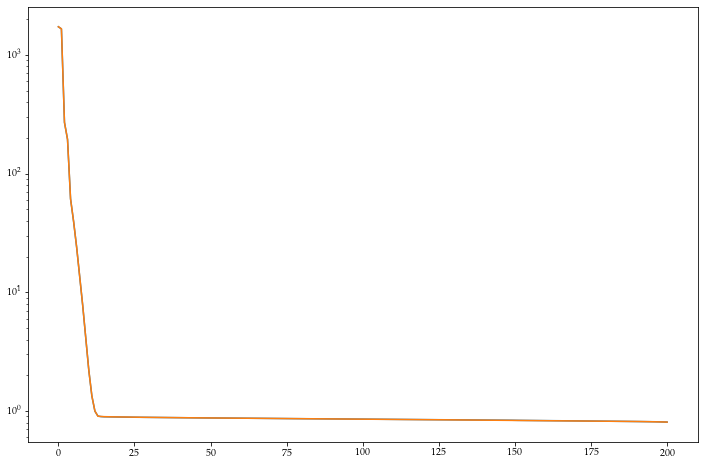

In [13]:
semilogy(usn)
semilogy(vsn)

In [14]:
dim = 15
Un = (uun[:,:dim].dot(np.diag(usn[:dim]).dot(uvn[:dim,:]))).reshape(n,n,steps)
Vn = (vun[:,:dim].dot(np.diag(vsn[:dim]).dot(vvn[:dim,:]))).reshape(n,n,steps)

Now that we've denoised the data (atleast somewhat) we just proceed as we did for the clean data.

In [15]:
# Take up to second order derivatives.
un = np.zeros((num_points,1))
vn = np.zeros((num_points,1))
utn = np.zeros((num_points,1))
vtn = np.zeros((num_points,1))
uxn = np.zeros((num_points,1))
uyn = np.zeros((num_points,1))
uxxn = np.zeros((num_points,1))
uxyn = np.zeros((num_points,1))
uyyn = np.zeros((num_points,1))
vxn = np.zeros((num_points,1))
vyn = np.zeros((num_points,1))
vxxn = np.zeros((num_points,1))
vxyn = np.zeros((num_points,1))
vyyn = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting polynomial for spatial derivative
Nt = N # and for time derivatives
deg = 4 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    
    # value of function
    un[p] = Un[x,y,t]
    vn[p] = Vn[x,y,t]
    
    # time derivatives
    utn[p] = PolyDiffPoint(Un[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]
    vtn[p] = PolyDiffPoint(Vn[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]
    
    # spatial derivatives
    ux_diff_n = PolyDiffPoint(Un[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    uy_diff_n = PolyDiffPoint(Un[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    vx_diff_n = PolyDiffPoint(Vn[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    vy_diff_n = PolyDiffPoint(Vn[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    ux_diff_yp_n = PolyDiffPoint(Un[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    ux_diff_ym_n = PolyDiffPoint(Un[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)
    vx_diff_yp_n = PolyDiffPoint(Vn[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    vx_diff_ym_n = PolyDiffPoint(Vn[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)
    
    uxn[p] = ux_diff_n[0]
    uyn[p] = uy_diff_n[0]
    uxxn[p] = ux_diff_n[1]
    uxyn[p] = (ux_diff_yp_n[0]-ux_diff_ym_n[0])/(2*dy)
    uyyn[p] = uy_diff_n[1]
    
    vxn[p] = vx_diff_n[0]
    vyn[p] = vy_diff_n[0]
    vxxn[p] = vx_diff_n[1]
    vxyn[p] = (vx_diff_yp_n[0]-vx_diff_ym_n[0])/(2*dy)
    vyyn[p] = vy_diff_n[1]

In [16]:
# Form Theta using up to quadratic polynomials in all variables.
X_data_n = np.hstack([un,vn])
X_ders_n = np.hstack([np.ones((num_points,1)), uxn, uyn, uxxn, uxyn, uyyn, vxn, vyn, vxxn, vxyn, vyyn])
X_ders_descr = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}','v_{x}', 'v_{y}','v_{xx}','v_{xy}','v_{yy}']
X_n, description = build_Theta(X_data_n, X_ders_n, X_ders_descr, 3, data_description = ['u','v'])

In [17]:
lam = 10**-5
d_tol = 1
c = TrainSTRidge(X_n,utn,lam,d_tol)
print_pde(c, description)

u_t = (0.094923 +0.000000i)u_{xx}
    + (0.095022 +0.000000i)u_{yy}
    + (0.945835 +0.000000i)u
    + (0.999732 +0.000000i)v^3
    + (-0.945751 +0.000000i)uv^2
    + (0.999784 +0.000000i)u^2v
    + (-0.945507 +0.000000i)u^3
   


In [18]:
lam = 10**-5
d_tol = 1
c = TrainSTRidge(X_n,vtn,lam,d_tol)
print_pde(c, description, ut = 'v_t')

v_t = (0.094980 +0.000000i)v_{xx}
    + (0.094898 +0.000000i)v_{yy}
    + (0.946891 +0.000000i)v
    + (-0.946863 +0.000000i)v^3
    + (-0.999398 +0.000000i)uv^2
    + (-0.946404 +0.000000i)u^2v
    + (-0.999661 +0.000000i)u^3
   


In [19]:
err = abs(np.array([(0.1-0.094870)*100/0.1,  (0.1-0.094934)*100/0.1,
                    (0.1-0.094970)*100/0.1,  (0.1-0.094939)*100/0.1,
                    (1-0.944877)*100,        (1-0.946222)*100,
                    (1-0.944831)*100,        (1-0.999442)*100,
                    (1-0.999758)*100,        (1-0.999674)*100,
                    (1-0.999770)*100,        (1-0.946074)*100,
                    (1-0.945130)*100,        (1-0.945752)*100]))
print(mean(err))
print(std(err))

3.7952857142857153
2.3844823552823935
